In [26]:
# This handles all the loading of the images and their bounding box into a pytorch tensor

import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as T


class WiderFaceDataset(Dataset):
    def __init__(self, root_dir, annotation_file, img_size=224, transform=None):
        """
        root_dir: path to WIDER FACE images
        annotation_file: path to annotation file (e.g., 'wider_face_train_bbx_gt.txt')
        img_size: size to resize images
        transform: torchvision transforms for data augmentation
        """

        self.root_dir = root_dir
        self.img_size = img_size
        self.transform = transform

        # Parse annotation file
        self.data = []
        with open(annotation_file, 'r') as f:
            lines = f.readlines()

        i = 0
        while i < len(lines):
            img_path = lines[i].strip()
            num_boxes = int(lines[i+1].strip())

            boxes = []
            if num_boxes > 0:
                for j in range(num_boxes):
                    # Each line: x, y, w, h, blur, expression, illumination, invalid, occlusion, pose
                    bbox_info = list(map(int, lines[i+2+j].strip().split()))
                    x, y, w, h = bbox_info[:4]
                    boxes.append([x, y, x+w, y+h])  # convert to x_min, y_min, x_max, y_max
                i = i + 2 + num_boxes
            else:
                # For when theres a picture with no bounding box, it takes 3 lines so requires extra work
                i +=3

            if len(boxes) == 0: #add pictures with no bounding box to tensor
                boxes = torch.zeros((0, 4), dtype=torch.float32)
            else:
                boxes = torch.tensor(boxes, dtype=torch.float32)

            self.data.append({
                'img_path': os.path.join(root_dir, img_path),
                'boxes': boxes
            })


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        image = Image.open(sample['img_path']).convert('RGB')
        #boxes = sample['boxes']
        boxes = sample['boxes'].clone()

        #Get original dimensions
        orig_w, orig_h = image.size

        #If there is a transform do that first
        if self.transform:
            image = self.transform(image)
    
        #now scale the boxes based on the original size
        scale_x = self.img_size / orig_w
        scale_y = self.img_size / orig_h
        boxes[:, [0,2]] = boxes[:, [0,2]] * scale_x
        boxes[:, [1,3]] = boxes[:, [1,3]] * scale_y

        

        target = {
            'boxes': boxes,
            'num_boxes': boxes.shape[0]
        }
        return image, target

In [27]:
# Example usage of transform
# Define transformations (resize + normalization)
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])
"""
root_dir: path to WIDER FACE images
annotation_file: path to annotation file (e.g., 'wider_face_train_bbx_gt.txt')
img_size: size to resize images
transform: torchvision transforms for data augmentation
"""

#Paths
img_root = '../Dataset/WIDER_train/images'
ann_file = '../Dataset/wider_ann/wider_face_train_bbx_gt.txt'

dataset = WiderFaceDataset(root_dir=img_root, annotation_file=ann_file, img_size=224, transform=transform)

# Test a single sample
img, target = dataset[0]
print(img.shape)          # torch.Size([3, 224, 224])
print(target['boxes'])    # Bounding boxes scaled to 224x224

torch.Size([3, 224, 224])
tensor([[ 98.2188,  53.3718, 124.9062,  77.4700]])


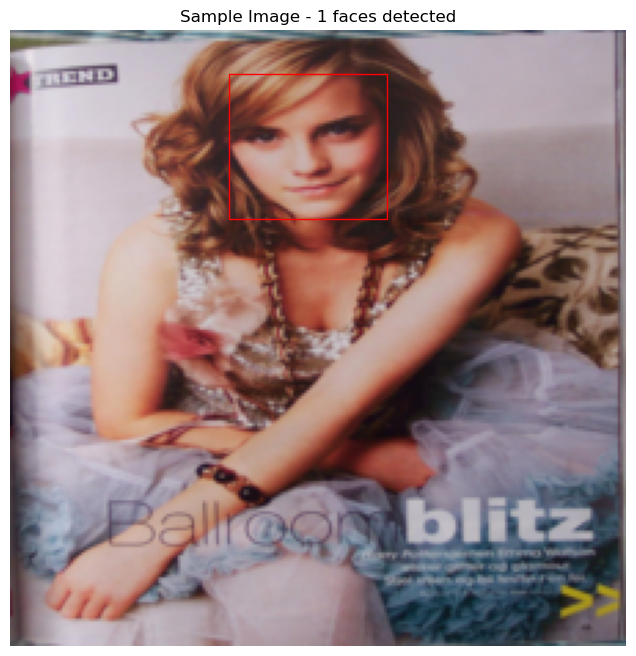

Bounding boxes: tensor([[ 78.9688,  15.3296, 136.5000,  68.3575]])


In [46]:
# 
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Load a sample image
img, target = dataset[1]

# Convert tensor back to image for display
# Undo normalization
img_denorm = img.clone()
img_denorm[0] = img_denorm[0] * 0.229 + 0.485
img_denorm[1] = img_denorm[1] * 0.224 + 0.456
img_denorm[2] = img_denorm[2] * 0.225 + 0.406

# Convert to numpy and transpose for matplotlib
img_display = img_denorm.permute(1, 2, 0).numpy()
img_display = img_display.clip(0, 1)  # Ensure values are in [0, 1] range

# Display the image
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(img_display)

# Draw bounding boxes
if target['num_boxes'] > 0:
    for box in target['boxes']:
        x_min, y_min, x_max, y_max = box.tolist()
        width = x_max - x_min
        height = y_max - y_min
        
        # Create rectangle patch
        rect = patches.Rectangle((x_min, y_min), width, height, 
                                 linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

ax.set_title(f"Sample Image - {target['num_boxes']} faces detected")
ax.axis('off')
plt.show()

# Print box coordinates
print(f"Bounding boxes: {target['boxes']}")

In [4]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# # ----------------------------
# # Simple Face Detection Net
# # ----------------------------
# # Input: 3x128x128 image
# # Output: 5 values per predicted box: [x_center, y_center, width, height, confidence]
# class SimpleFaceDetector(nn.Module):
#     def __init__(self):
#         super(SimpleFaceDetector, self).__init__()
        
#         # CNN backbone
#         self.features = nn.Sequential(
#             nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2),  # 64x64
#             nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2),  # 32x32
#             nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2),  # 16x16
#         )
        
#         # Detection head (predict boxes and confidence for 16x16 grid)
#         # Here we predict 1 box per grid cell
#         self.detector = nn.Conv2d(64, 5, kernel_size=1)  # 5 = [x, y, w, h, conf]
        
#     def forward(self, x):
#         x = self.features(x)
#         x = self.detector(x)  # shape: (batch, 5, 16, 16)
        
#         # reshape to (batch, num_boxes, 5)
#         batch_size = x.size(0)
#         x = x.permute(0, 2, 3, 1)  # (batch, 16, 16, 5)
#         x = x.reshape(batch_size, -1, 5)  # flatten grid → (batch, 256, 5)
#         return x


In [5]:
# # Create the network
# net = SimpleFaceDetector()

# # Dummy input: batch of 2 images, 3 channels, 128x128
# dummy_input = torch.randn(2, 3, 128, 128)

# # Forward pass
# output = net(dummy_input)
# print("Output shape:", output.shape)  # (batch, num_boxes, 5)
